# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import ast

from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print("Number of rows and columns in general demographic data: ", azdias.shape)
print("Number of rows and columns in feature summary data: ", feat_info.shape)

display(azdias.describe())
display(azdias.head())
display(feat_info.head())


Number of rows and columns in general demographic data:  (891221, 85)
Number of rows and columns in feature summary data:  (85, 4)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [4]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
# Identify missing or unknown data values and convert them to NaNs.

df = feat_info[['attribute','missing_or_unknown']]
missing_dict = {}
for index, row in df.iterrows():
    try:
        if row['missing_or_unknown'][1:-1].split(',')[0] == '':
            missing_dict[row['attribute']] = ''
        else:
            missing_dict[row['attribute']] = ast.literal_eval(row['missing_or_unknown'])
    except:
        mlist = []
        for c in row['missing_or_unknown'][1:-1].split(','):
            try:
                mlist.append(int(c))
            except:
                mlist.append(c)
        missing_dict[row['attribute']] = mlist
                

display(azdias.head())
azdias_nan = azdias.replace(missing_dict, np.nan)
display(azdias_nan.head())


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

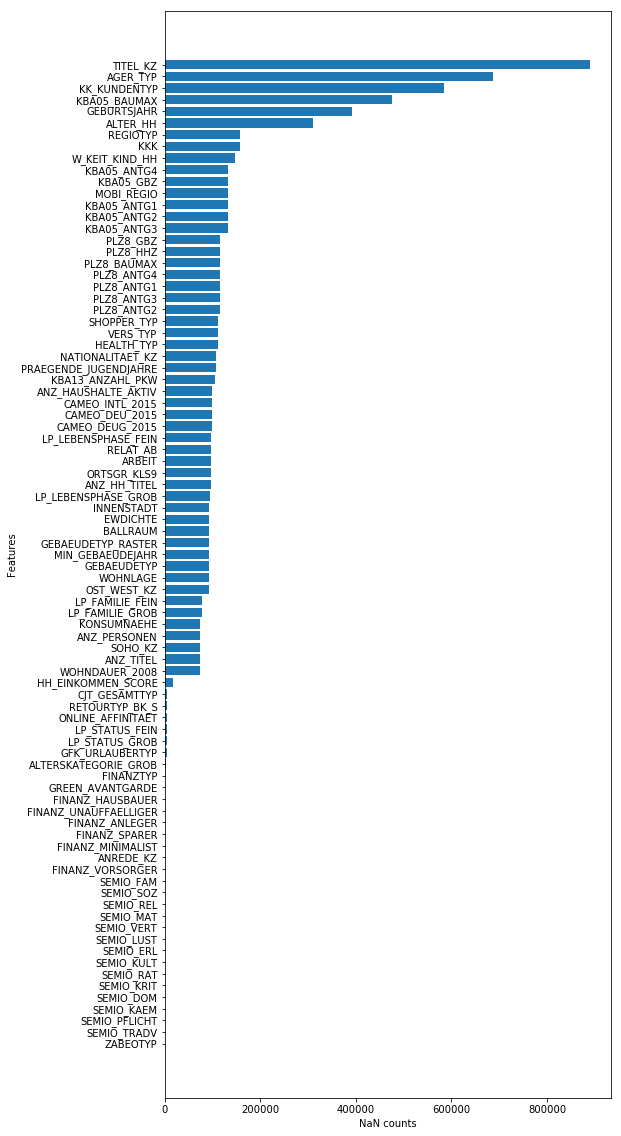

In [6]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

df_nans = azdias_nan.isnull().sum()
data = [('feature', list(df_nans.index)), ('nan_count', list(df_nans.values))]
azdias_nan_counts = pd.DataFrame.from_items(data)

azdias_nan_counts = azdias_nan_counts.sort_values(by='nan_count')
#azdias_nan_counts
plt.figure(figsize=(8,20))
plt.barh(range(len(azdias_nan_counts)), azdias_nan_counts.nan_count.tolist())
plt.yticks(range(len(azdias_nan_counts)), azdias_nan_counts.feature.tolist())
plt.xlabel('NaN counts')
plt.ylabel('Features')


In [7]:
# Investigate patterns in the amount of missing data in each column.
df_nans = azdias_nan.isnull().sum()
nan_percent = list(map(lambda x : round(x/891221*100, 2), list(df_nans.values)))

data = [('feature', list(df_nans.index)), ('nan_count', list(df_nans.values)), ('percent', nan_percent)]
azdias_nan_pattern = pd.DataFrame.from_items(data)

info_lvl = []
for feat in list(azdias_nan_pattern['feature']):
    info_lvl.append(list(feat_info[feat_info['attribute'] == feat].information_level.values)[0])

var_typ = []
for feat in list(azdias_nan_pattern['feature']):
    var_typ.append(list(feat_info[feat_info['attribute'] == feat].type.values)[0])
    
azdias_nan_pattern['info_level'] = info_lvl
azdias_nan_pattern['var_type'] = var_typ

azdias_nan_pattern.sort_values(by='percent', ascending=False).head(10)


,feature,nan_count,percent,info_level,var_type
40,TITEL_KZ,889061,99.76,person,categorical
0,AGER_TYP,685843,76.96,person,categorical
47,KK_KUNDENTYP,584612,65.60,household,categorical
64,KBA05_BAUMAX,476524,53.47,microcell_rr3,mixed
11,GEBURTSJAHR,392318,44.02,person,numeric
43,ALTER_HH,310267,34.81,household,interval
70,KKK,158064,17.74,region_rr1,ordinal
73,REGIOTYP,158064,17.74,region_rr1,ordinal
48,W_KEIT_KIND_HH,147988,16.61,household,ordinal
60,KBA05_ANTG1,133324,14.96,microcell_rr3,ordinal


In [8]:
# Investigate patterns in the amount of missing data in each column.
# Columns with NaN count = Zero

display(azdias_nan_pattern[azdias_nan_pattern['nan_count'] == 0])


,feature,nan_count,percent,info_level,var_type
2,ANREDE_KZ,0,0.0,person,categorical
4,FINANZ_MINIMALIST,0,0.0,person,ordinal
5,FINANZ_SPARER,0,0.0,person,ordinal
6,FINANZ_VORSORGER,0,0.0,person,ordinal
7,FINANZ_ANLEGER,0,0.0,person,ordinal
8,FINANZ_UNAUFFAELLIGER,0,0.0,person,ordinal
9,FINANZ_HAUSBAUER,0,0.0,person,ordinal
10,FINANZTYP,0,0.0,person,categorical
13,GREEN_AVANTGARDE,0,0.0,person,categorical
24,SEMIO_SOZ,0,0.0,person,ordinal


In [9]:
# Investigate patterns in the amount of missing data in each column.
# Columns with NaN count percent greater than 0 and less than 30 percent

azdias_col_pattern = azdias_nan_pattern[azdias_nan_pattern['nan_count'] != 0]
azdias_col_pattern = azdias_col_pattern[azdias_col_pattern['percent'] < 30]

display(azdias_col_pattern.sort_values('nan_count'))



,feature,nan_count,percent,info_level,var_type
1,ALTERSKATEGORIE_GROB,2881,0.32,person,ordinal
23,RETOURTYP_BK_S,4854,0.54,person,ordinal
20,LP_STATUS_GROB,4854,0.54,person,categorical
19,LP_STATUS_FEIN,4854,0.54,person,categorical
12,GFK_URLAUBERTYP,4854,0.54,person,categorical
3,CJT_GESAMTTYP,4854,0.54,person,categorical
72,ONLINE_AFFINITAET,4854,0.54,region_rr1,ordinal
46,HH_EINKOMMEN_SCORE,18348,2.06,household,ordinal
44,ANZ_PERSONEN,73499,8.25,household,numeric
49,WOHNDAUER_2008,73499,8.25,household,ordinal


In [10]:
# Investigate patterns in the amount of missing data in each column.
azdias_nan_pattern[azdias_nan_pattern['percent'] >= 30]


,feature,nan_count,percent,info_level,var_type
0,AGER_TYP,685843,76.96,person,categorical
11,GEBURTSJAHR,392318,44.02,person,numeric
40,TITEL_KZ,889061,99.76,person,categorical
43,ALTER_HH,310267,34.81,household,interval
47,KK_KUNDENTYP,584612,65.60,household,categorical
64,KBA05_BAUMAX,476524,53.47,microcell_rr3,mixed


In [11]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

labels_drop = list(azdias_nan_pattern[azdias_nan_pattern['percent'] >= 30]['feature'])
print("Features to drop: ", labels_drop)

# Remove column outliers
azdias_rem_column_outliers = azdias_nan.drop(labels_drop, axis=1)
display(azdias_rem_column_outliers.shape)

Features to drop:  ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

The distribution of missing data across different column is shown in the bar plot above. It clearly indicates a distinctly measureable shift from columns with low NaNs to columns with high NaNs. When looked closely interms of percentage of missing data per column the shift supports the raw counts based inference at a value of greater than or equal to 30 percent. Using this threshold 6 colums were dropped namely: 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'.

The pattern among the features in terms of missing value was investigated. It was observed that all the features with no missing values belong to the information level 'person'. Additionally it was noticed that there were few groups of features that had same number of missing values. The features with same number of missing values belonged more or less to the same information level. For example, all the PLZ8 related features had same number of missing values (same for KBA05 and CAMEO). 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. Make sure you report your observations in the discussion section. **Either way, you should continue your analysis below using just the subset of the data with few or no missing values.**

In [12]:
from collections import Counter

# How much data is missing in each row of the dataset?
azdias_nan = azdias_rem_column_outliers
df_rownans = azdias_nan.isnull().sum(axis=1)

row_data = [('row_nan_count', list(Counter(list(df_rownans)).keys())), ('record_count', list(Counter(list(df_rownans)).values()))]
df_row = pd.DataFrame.from_items(row_data)
df_row = df_row[df_row['row_nan_count'] > 0].sort_values(by='row_nan_count')

<function matplotlib.pyplot.show>

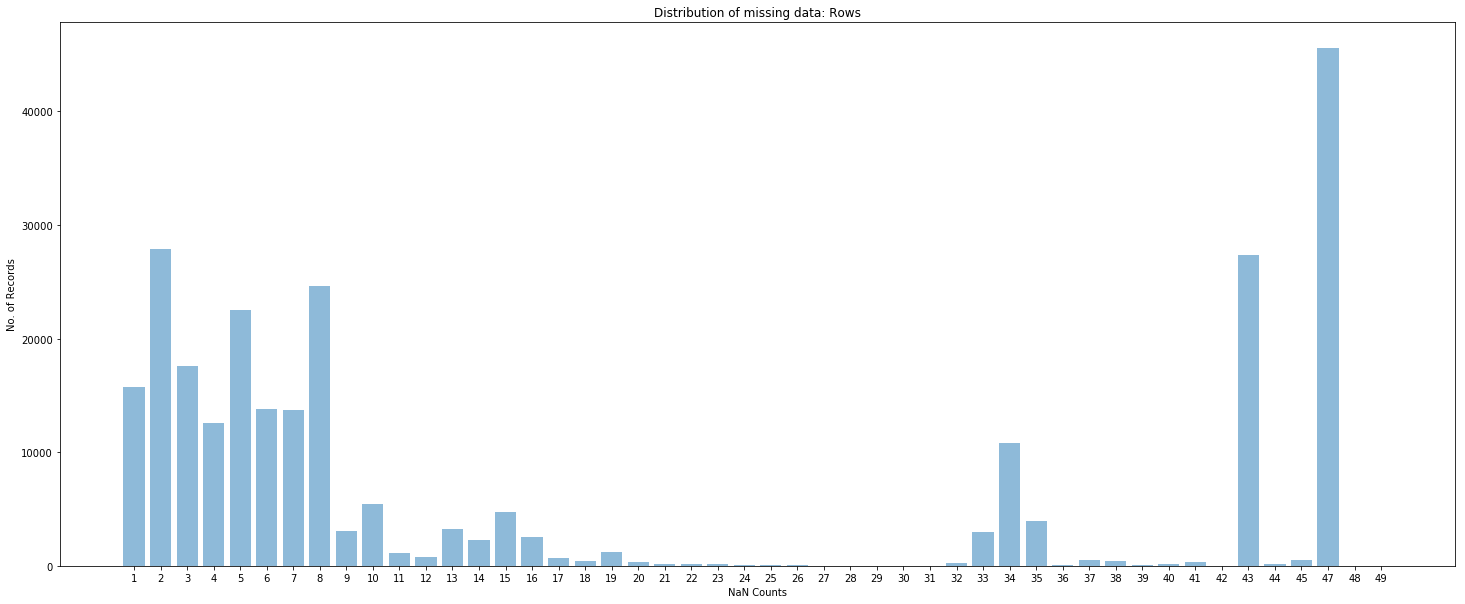

In [13]:
# Distribution of missing data in rows
#df_row = df_row.sort_values(by='record_count')

plt.figure(figsize=(25,10))
objects = list(df_row.row_nan_count)
y_pos = np.arange(len(objects))
nan_counts = list(df_row.record_count)

plt.bar(y_pos, nan_counts, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('No. of Records')
plt.xlabel('NaN Counts')
plt.title('Distribution of missing data: Rows')

plt.show

In [14]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

display(df_row[df_row['row_nan_count'] <= 31].sum())
display(azdias_nan.shape)

azdias_row_lownan = azdias_nan[azdias_nan.isnull().sum(axis=1) <= 31]
display(azdias_row_lownan.head())
display(azdias_row_lownan.shape)

azdias_row_highnan = azdias_nan[azdias_nan.isnull().sum(axis=1) > 31]
display(azdias_row_highnan.head())
display(azdias_row_highnan.shape)

row_nan_count       496
record_count     174861
dtype: int64

(891221, 79)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


(798070, 79)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,3.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,3.0,2,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(93151, 79)

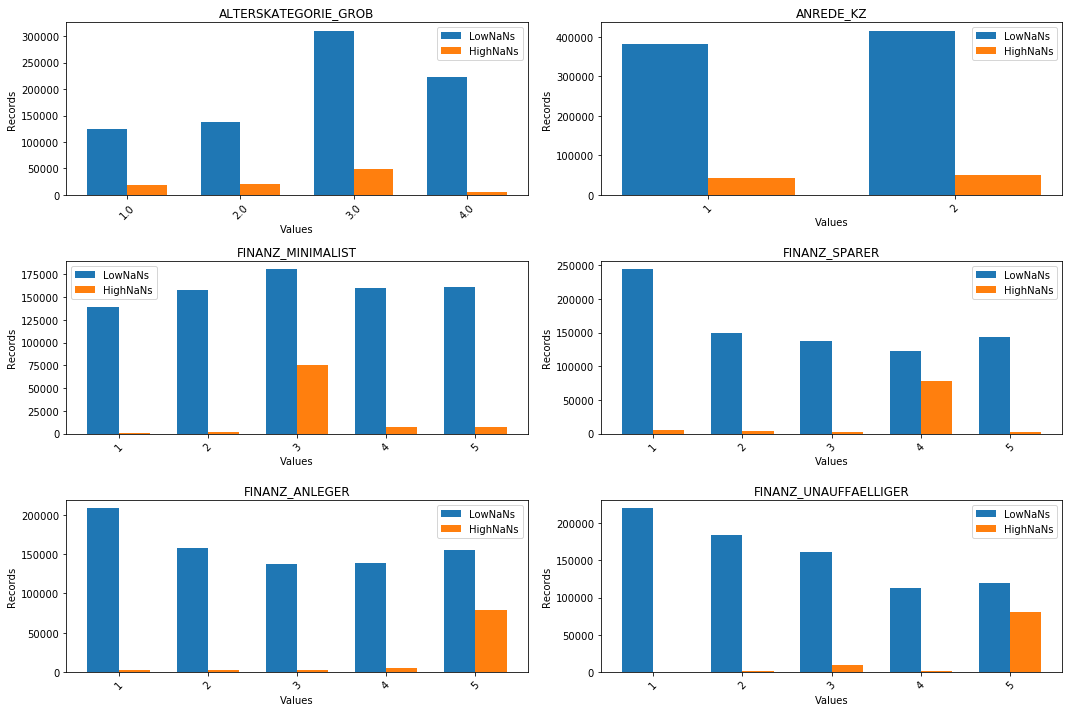

In [15]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def create_plots(ax, feat, df):
    width = 0.35
    ind = df['Values']
    rects1 = ax.bar(ind, df['LowNaNs'],width)
    rects2 = ax.bar(ind+width, df['HighNaNs'], width)
    ax.set_ylabel('Records')
    ax.set_xlabel('Values')
    ax.set_title(feat)
    xTickMarks = df['Values']
    ax.set_xticks(ind+width/2)
    xtickNames = ax.set_xticklabels(xTickMarks)
    plt.setp(xtickNames, rotation=45, fontsize=10)
    ax.legend( (rects1[0], rects2[0]), ('LowNaNs', 'HighNaNs') )
    

#def comparison(azdias_row_lownan, azdias_row_highnan, feature):
#    df_data = [('Values', list(azdias_row_lownan.groupby(feature).size().index)),
#            ('LowNaNs', azdias_row_lownan.groupby(feature).size().values), 
#           ('HighNaNs', azdias_row_highnan.groupby(feature).size().values)]
#    df = pd.DataFrame.from_items(df_data)
#    return df


def comparison(azdias_row_lownan, azdias_row_highnan, feature):
    idx = list(azdias_row_lownan.groupby(feature).size().index)
    lownans = []
    for i in idx:
        siz = azdias_row_lownan[azdias_row_lownan[feature] == i].shape[0]
        lownans.append(siz)
    highnans = []
    for i in idx:
        siz = azdias_row_highnan[azdias_row_highnan[feature] == i].shape[0]
        highnans.append(siz)
    df_data = [('Values', idx),
            ('LowNaNs', lownans), 
           ('HighNaNs', highnans)]
    df = pd.DataFrame.from_items(df_data)
    
    return df

#display(azdias_row_lownan[azdias_row_lownan['ANREDE_KZ'] == 1].shape[0])

feat = ['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_ANLEGER', 
        'FINANZ_UNAUFFAELLIGER']

#display(azdias_row_highnan['GREEN_AVANTGARDE'])
#feat = ['ANREDE_KZ','ALTERSKATEGORIE_GROB','GREEN_AVANTGARDE','FINANZTYP','SEMIO_KULT','ZABEOTYP']

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(15,10))

df1 = comparison(azdias_row_lownan, azdias_row_highnan, feat[0])
df2 = comparison(azdias_row_lownan, azdias_row_highnan, feat[1])
df3 = comparison(azdias_row_lownan, azdias_row_highnan, feat[2])
df4 = comparison(azdias_row_lownan, azdias_row_highnan, feat[3])
df5 = comparison(azdias_row_lownan, azdias_row_highnan, feat[4])
df6 = comparison(azdias_row_lownan, azdias_row_highnan, feat[5])
create_plots(ax1, feat[0], df1)
create_plots(ax2, feat[1], df2)
create_plots(ax3, feat[2], df3)
create_plots(ax4, feat[3], df4)
create_plots(ax5, feat[4], df5)
create_plots(ax6, feat[5], df6)
plt.tight_layout()

plt.show()

#### Discussion 1.1.3: Assess Missing Data in Each Row

Based of the distribution of row NaN counts across records a threshold of 31. The data was divided into two subsets: 1) Low NaNs: with rows that have less than or equal to 31 NaNs; and 2) High NaNs: With rows that have more than 31 NaNs.

The distributions of data values on columns that are missing very little data (Low NaNs) was compared with data values on clumns that have high missing data (High NaNs) for 6 features. Out of six, only two showed more or less similar distribution between the groups. The rest were different between the two groups. The data with many missing values could potentially be different from the data with few or no missing values which implicates a further indepth investigation of dropped records.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [16]:
# How many features are there of each data type?
feat_info.groupby('type').size()


type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [17]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
display(feat_info[feat_info['type'] == "categorical"])

feat_cat = feat_info[feat_info['type'] == "categorical"] #['attribute']
column_list = []
for col in list(azdias_row_lownan.columns):
    if col in list(feat_cat['attribute']):
        column_list.append(col)

#df_cat = azdias_row_lownan[feat_info[feat_info['type'] == "categorical"]['attribute']]
#print(column_list)
#column_list = list(df_cat.columns)
for column_name in column_list:
    print(column_name, "=>", azdias_row_lownan[column_name].unique())
    

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]


ANREDE_KZ => [2 1]
CJT_GESAMTTYP => [  5.   3.   2.   4.   1.   6.  nan]
FINANZTYP => [1 6 5 2 4 3]
GFK_URLAUBERTYP => [ 10.   1.   5.  12.   9.   3.   8.  11.   4.   2.   7.   6.  nan]
GREEN_AVANTGARDE => [0 1]
LP_FAMILIE_FEIN => [  5.   1.  nan  10.   2.   7.  11.   8.   4.   6.   9.   3.]
LP_FAMILIE_GROB => [  3.   1.  nan   5.   2.   4.]
LP_STATUS_FEIN => [  2.   3.   9.   4.   1.  10.   5.   8.   6.   7.  nan]
LP_STATUS_GROB => [  1.   2.   4.   5.   3.  nan]
NATIONALITAET_KZ => [  1.   3.   2.  nan]
SHOPPER_TYP => [  3.   2.   1.   0.  nan]
SOHO_KZ => [ 1.  0.]
VERS_TYP => [  2.   1.  nan]
ZABEOTYP => [5 3 4 1 6 2]
GEBAEUDETYP => [ 8.  1.  3.  2.  6.  4.  5.]
OST_WEST_KZ => ['W' 'O']
CAMEO_DEUG_2015 => ['8' '4' '2' '6' '1' '9' '5' '7' nan '3']
CAMEO_DEU_2015 => ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D' '9E'
 nan '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' 

In [18]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_lownan_encoded = pd.get_dummies(azdias_row_lownan, columns = column_list)
azdias_lownan_encoded.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
1,1.0,1,5,2,5,4,5,3.0,21.0,6.0,...,0,1,0,0,0,0,0,0,0,0
2,3.0,1,4,1,2,3,5,3.0,3.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,4.0,4,2,5,2,1,2,2.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,3.0,4,3,4,1,3,2,3.0,32.0,10.0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,3,1,5,2,2,5,3.0,8.0,2.0,...,0,0,0,1,0,0,0,0,0,0


#### Discussion 1.2.1: Re-Encode Categorical Features

The categorical variables that were present after removing the high NaN features were retained. Looking at the values of retained categorical variables reflects that most of them had multi-level categories. The pandas feature encoding method was used (pd.get_dummies()). This step breaks apart the multi-level categorical feature into a series of binary features. This step led to a total of 199 columns.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [19]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

azdias_lownan_encoded['PRAEGENDE_JUGENDJAHRE'].unique()

array([ 14.,  15.,   8.,   3.,  10.,  11.,   5.,   9.,   6.,   4.,  nan,
         2.,   1.,  12.,  13.,   7.])

In [20]:
# engineer two new variables
#- 1: 40-49 => 1, 2
#- 2: 50-59 => 3, 4
#- 3: 60-69 => 5, 6, 7
#- 4: 70-79 => 8, 9
#- 5: 80-89 => 10, 11, 12, 13
#- 6: 90-99 => 14, 15

prae_decade = []
for val in azdias_lownan_encoded['PRAEGENDE_JUGENDJAHRE']:
    if val in [1,2]:
        prae_decade.append(1)
    elif val in [3,4]:
        prae_decade.append(2)
    elif val in [5,6,7]:
        prae_decade.append(3)
    elif val in [8,9]:
        prae_decade.append(4)
    elif val in [10,11,12,13]:
        prae_decade.append(5)
    elif val in [14,15]:
        prae_decade.append(6)
    else:
        prae_decade.append(np.nan)
        
azdias_lownan_encoded['PRAEGENDE_JUGENDJAHRE_DEC'] = prae_decade

# 0: mainstream
# 1: avantgarde

prae_mvmt = []
for val in azdias_lownan_encoded['PRAEGENDE_JUGENDJAHRE']:
    if val in [1,3,5,8,10,12,14]:
        prae_mvmt.append(0)
    elif val in [2,4,6,7,9,11,13,15]:
        prae_mvmt.append(1)
    else:
        prae_mvmt.append(np.nan)
        
azdias_lownan_encoded['PRAEGENDE_JUGENDJAHRE_MVMT'] = prae_mvmt

#print(azdias_lownan_encoded['PRAEGENDE_JUGENDJAHRE_DEC'].unique())
#print(azdias_lownan_encoded['PRAEGENDE_JUGENDJAHRE_MVMT'].unique())

# Drop the original column
azdias_lownan_encoded = azdias_lownan_encoded.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1)
#print(list(azdias_lownan_encoded.columns))

In [21]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

azdias_lownan_encoded['CAMEO_INTL_2015'].unique()

#import math

cameo_wlth = []
cameo_lstg = []
for val in azdias_lownan_encoded['CAMEO_INTL_2015']:
    x = float(val)
    if math.isnan(x):
        cameo_wlth.append(np.nan)
        cameo_lstg.append(np.nan)
    else:
        wlth = list(str(val))[0]
        lstg = list(str(val))[1]
        cameo_wlth.append(int(wlth))
        cameo_lstg.append(int(lstg))
        
azdias_lownan_encoded['CAMEO_INTL_2015_WLTH'] = cameo_wlth
azdias_lownan_encoded['CAMEO_INTL_2015_LSTG'] = cameo_lstg

#print(azdias_lownan_encoded['CAMEO_INTL_2015_WLTH'].unique())
#print(azdias_lownan_encoded['CAMEO_INTL_2015_LSTG'].unique())

# Drop the original column
azdias_lownan_encoded = azdias_lownan_encoded.drop(['CAMEO_INTL_2015'], axis=1)
#print(list(azdias_lownan_encoded.columns))


In [22]:
# Investigate mixed type variables

feat_mixed = feat_info[feat_info['type'] == "mixed"]
#display(feat_mixed) #['attribute']
column_mix = []
for col in list(azdias_lownan_encoded.columns):
    if col in list(feat_mixed['attribute']):
        column_mix.append(col)

#df_cat = azdias_row_lownan[feat_info[feat_info['type'] == "categorical"]['attribute']]
#column_list = list(df_cat.columns)
for column_name in column_mix:
    x = list(azdias_lownan_encoded[column_name].dropna().astype(int).unique())
    x.sort()
    print(column_name, "=>", x)
    

LP_LEBENSPHASE_FEIN => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
LP_LEBENSPHASE_GROB => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
WOHNLAGE => [0, 1, 2, 3, 4, 5, 7, 8]
PLZ8_BAUMAX => [1, 2, 3, 4, 5]


In [23]:
# Investigate "WOHNLAGE" and engineer a new binary variables.
# 0: no score calculated
# 1-5: not rural (0)
# 7-8: rural (1)

azdias_lownan_encoded['WOHNLAGE'].unique()

#import math

wohnlage_rural = []
for val in azdias_lownan_encoded['WOHNLAGE']:
    if val in [1,2,3,4,5]:
        wohnlage_rural.append(0)
    elif val in [7,8]:
        wohnlage_rural.append(1)
    else:
        wohnlage_rural.append(np.nan)
        
azdias_lownan_encoded['WOHNLAGE_RURAL'] = wohnlage_rural
azdias_lownan_encoded = azdias_lownan_encoded.drop(['WOHNLAGE'], axis=1)


In [24]:
# Investigate "PLZ8_BAUMAX" and engineer one new variables.
# building type in PLZ8 region: business or non-business)
# 1 to 4: family
# 5: business

azdias_lownan_encoded['PLZ8_BAUMAX'].unique()

plz8_btype = []

for val in azdias_lownan_encoded['PLZ8_BAUMAX']:
    if val in [1,2,3,4]:
        plz8_btype.append(0)
    elif val in [5]:
        plz8_btype.append(1)
    else:
        plz8_btype.append(np.nan)
        
azdias_lownan_encoded['PLZ8_BTYPE'] = plz8_btype
azdias_lownan_encoded = azdias_lownan_encoded.drop(['PLZ8_BAUMAX'], axis=1)

In [25]:
# Drop remaining mixed type variables
azdias_lownan_encoded = azdias_lownan_encoded.drop(['LP_LEBENSPHASE_FEIN'], axis=1)
azdias_lownan_encoded = azdias_lownan_encoded.drop(['LP_LEBENSPHASE_GROB'], axis=1)

In [26]:
print(list(azdias_lownan_encoded.columns))

['ALTERSKATEGORIE_GROB', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEIT', 'ORTSGR_KLS9', 'RELAT_AB', 'ANREDE_KZ_1', 'ANREDE_KZ_2', 'CJT_GESAMTTYP_1.0', 'CJT_GESAMTTYP_2.0', 'CJT_GESAMTTYP_3.0', 'CJT_GESAMTTYP_4.0', 'CJT_GESAMTTYP_5.0', 'CJT_GESA

#### Discussion 1.2.2: Engineer Mixed-Type Features

After dropping the high NaN features there were 6 mixed type features in the dataset. Two of the mixed-type features were processed separately as a first step. The processing step involved spliting out the value strings into interval-type (PRAEGENDE_JUGENDJAHRE) components to create new features. Or creating ordinal type features by spliting the values (CAMEO_INTL_2015). The interval-type and ordinal features created can be kept without changes.

The remaining 4 mixed type features were also investigated for deciding whether to retain or drop those. The 'WOHNLAGE' feature seemed ordinal type ranging from 1-5 indicating very good to very poor neighborhood. However, 6-7 indicated a rural setting. Hence, this feature was used to create a binary rural flag feture (WOHNLAGE_RURAL).

Similary the PLZ8_BAUMAX feature showed ordinal building type (number of family homes) from 1-4. But 5 indicated a business type building. So this feature was used to create a binary feature indicating nature of building type: business or non-business.

The original colums were dropped after creating the new columns with required value formats.

Looking at the remaining two mixed type features, LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB, it seemed difficult to uncouple the contained information into multiple interval or ordinal type features. Additionally the information seemed bit redundant with few other features already retained earlier. Also converting to binary type feature would add a significant number of columns to the dataset. Based of all the above findings it was decided to drop these two features.


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [100]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)


In [ ]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [27]:
def clean_data(df, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    
    # 1. convert missing value codes into NaNs, ...
    df_feat = feat_info[['attribute','missing_or_unknown']]
    missing_dict = {}
    for index, row in df_feat.iterrows():
        try:
            if row['missing_or_unknown'][1:-1].split(',')[0] == '':
                missing_dict[row['attribute']] = ''
            else:
                missing_dict[row['attribute']] = ast.literal_eval(row['missing_or_unknown'])
        except:
            mlist = []
            for c in row['missing_or_unknown'][1:-1].split(','):
                try:
                    mlist.append(int(c))
                except:
                    mlist.append(c)
            missing_dict[row['attribute']] = mlist
                
    azdias_nan = df.replace(missing_dict, np.nan)

    # 2. remove selected columns and rows, ...

    # 2.1 remove column outliers
    labels_drop = ['AGER_TYP','GEBURTSJAHR','TITEL_KZ','ALTER_HH','KK_KUNDENTYP','KBA05_BAUMAX']
    azdias_remove_outliers = azdias_nan.drop(labels_drop, axis=1)

    # 2.2 remove row outliers
    azdias_nan = azdias_remove_outliers
    azdias_row_lownan = azdias_nan[azdias_nan.isnull().sum(axis=1) <= 31]

    # 3. select, re-encode, and engineer column values.
    feat_cat = feat_info[feat_info['type'] == "categorical"]
    column_list = []
    for col in list(azdias_row_lownan.columns):
        if col in list(feat_cat['attribute']):
            column_list.append(col)

    azdias_lownan_encoded = pd.get_dummies(azdias_row_lownan, columns = column_list)

    # 4. Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables
    prae_decade = []
    for val in azdias_lownan_encoded['PRAEGENDE_JUGENDJAHRE']:
        if val in [1,2]:
            prae_decade.append(1)
        elif val in [3,4]:
            prae_decade.append(2)
        elif val in [5,6,7]:
            prae_decade.append(3)
        elif val in [8,9]:
            prae_decade.append(4)
        elif val in [10,11,12,13]:
            prae_decade.append(5)
        elif val in [14,15]:
            prae_decade.append(6)
        else:
            prae_decade.append(np.nan)
        
    azdias_lownan_encoded['PRAEGENDE_JUGENDJAHRE_DEC'] = prae_decade

    # 0: mainstream
    # 1: avantgarde
    prae_mvmt = []
    for val in azdias_lownan_encoded['PRAEGENDE_JUGENDJAHRE']:
        if val in [1,3,5,8,10,12,14]:
            prae_mvmt.append(0)
        elif val in [2,4,6,7,9,11,13,15]:
            prae_mvmt.append(1)
        else:
            prae_mvmt.append(np.nan)
            
    azdias_lownan_encoded['PRAEGENDE_JUGENDJAHRE_MVMT'] = prae_mvmt
    
    # 5. Investigate "CAMEO_INTL_2015" and engineer two new variables.
    cameo_wlth = []
    cameo_lstg = []
    for val in azdias_lownan_encoded['CAMEO_INTL_2015']:
        x = float(val)
        if math.isnan(x):
            cameo_wlth.append(np.nan)
            cameo_lstg.append(np.nan)
        else:
            wlth = list(str(val))[0]
            lstg = list(str(val))[1]
            cameo_wlth.append(int(wlth))
            cameo_lstg.append(int(lstg))
        
    azdias_lownan_encoded['CAMEO_INTL_2015_WLTH'] = cameo_wlth
    azdias_lownan_encoded['CAMEO_INTL_2015_LSTG'] = cameo_lstg
    
    # Investigate "WOHNLAGE" and engineer a new binary variables.
    # 0: no score calculated
    # 1-5: not rural (0)
    # 7-8: rural (1)

    azdias_lownan_encoded['WOHNLAGE'].unique()

    wohnlage_rural = []
    for val in azdias_lownan_encoded['WOHNLAGE']:
        if val in [1,2,3,4,5]:
            wohnlage_rural.append(0)
        elif val in [7,8]:
            wohnlage_rural.append(1)
        else:
            wohnlage_rural.append(np.nan)
        
    azdias_lownan_encoded['WOHNLAGE_RURAL'] = wohnlage_rural
    
    # Investigate "PLZ8_BAUMAX" and engineer one new variables.
    # building type in PLZ8 region: business or non-business)
    # 1 to 4: family
    # 5: business

    azdias_lownan_encoded['PLZ8_BAUMAX'].unique()

    plz8_btype = []
    for val in azdias_lownan_encoded['PLZ8_BAUMAX']:
        if val in [1,2,3,4]:
            plz8_btype.append(0)
        elif val in [5]:
            plz8_btype.append(1)
        else:
            plz8_btype.append(np.nan)
        
    azdias_lownan_encoded['PLZ8_BTYPE'] = plz8_btype

    
    
    # 6. Drop engineered columns
    azdias_lownan_encoded = azdias_lownan_encoded.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1)
    azdias_lownan_encoded = azdias_lownan_encoded.drop(['CAMEO_INTL_2015'], axis=1)
    azdias_lownan_encoded = azdias_lownan_encoded.drop(['WOHNLAGE'], axis=1)
    azdias_lownan_encoded = azdias_lownan_encoded.drop(['PLZ8_BAUMAX'], axis=1)
    
    # 7. Drop remaining mixed type variables
    azdias_lownan_encoded = azdias_lownan_encoded.drop(['LP_LEBENSPHASE_FEIN'], axis=1)
    azdias_lownan_encoded = azdias_lownan_encoded.drop(['LP_LEBENSPHASE_GROB'], axis=1)
    
    # 8. Return the cleaned dataframe.
    return azdias_lownan_encoded
    

In [28]:
demo_df = clean_data(azdias, feat_info)
display(demo_df.shape)

(798070, 199)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values before applying your scaler. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [29]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
#from sklearn.preprocessing import Imputer, StandardScaler

fill_NaN = Imputer(missing_values=np.nan, strategy='most_frequent', axis=1)
imputed_df = pd.DataFrame(fill_NaN.fit_transform(demo_df))
imputed_df.columns = demo_df.columns
imputed_df.index = demo_df.index

imputed_df.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DEC,PRAEGENDE_JUGENDJAHRE_MVMT,CAMEO_INTL_2015_WLTH,CAMEO_INTL_2015_LSTG,WOHNLAGE_RURAL,PLZ8_BTYPE
1,1.0,1.0,5.0,2.0,5.0,4.0,5.0,3.0,1.0,5.0,...,0.0,0.0,0.0,0.0,6.0,0.0,5.0,1.0,0.0,0.0
2,3.0,1.0,4.0,1.0,2.0,3.0,5.0,3.0,3.0,4.0,...,0.0,0.0,0.0,0.0,6.0,1.0,2.0,4.0,0.0,0.0
3,4.0,4.0,2.0,5.0,2.0,1.0,2.0,2.0,2.0,5.0,...,0.0,0.0,0.0,0.0,4.0,0.0,1.0,2.0,1.0,0.0
4,3.0,4.0,3.0,4.0,1.0,3.0,2.0,3.0,5.0,6.0,...,0.0,0.0,0.0,0.0,4.0,0.0,4.0,3.0,0.0,0.0
5,1.0,3.0,1.0,5.0,2.0,2.0,5.0,3.0,3.0,2.0,...,0.0,0.0,0.0,0.0,2.0,0.0,5.0,4.0,1.0,0.0


In [30]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(imputed_df))
scaled_df.columns = imputed_df.columns
scaled_df.index = imputed_df.index

scaled_df.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DEC,PRAEGENDE_JUGENDJAHRE_MVMT,CAMEO_INTL_2015_WLTH,CAMEO_INTL_2015_LSTG,WOHNLAGE_RURAL,PLZ8_BTYPE
1,-1.733624,-1.494590,1.537915,-1.040683,1.465956,0.958624,1.339321,1.037380,-1.643476,0.443209,...,-0.189538,-0.179781,-0.192767,-0.089763,1.110235,-0.530406,1.186057,-1.233515,-0.552786,-0.372694
2,0.208164,-1.494590,0.864556,-1.766970,-0.571003,0.244102,1.339321,1.037380,-0.286693,-0.072009,...,-0.189538,-0.179781,-0.192767,-0.089763,1.110235,1.885350,-0.831903,0.766015,-0.552786,-0.372694
3,1.179058,0.683149,-0.482163,1.138176,-0.571003,-1.184941,-0.791198,-0.112469,-0.965085,0.443209,...,-0.189538,-0.179781,-0.192767,-0.089763,-0.107055,-0.530406,-1.504557,-0.567005,1.809020,-0.372694
4,0.208164,0.683149,0.191196,0.411889,-1.249989,0.244102,-0.791198,1.037380,1.070090,0.958427,...,-0.189538,-0.179781,-0.192767,-0.089763,-0.107055,-0.530406,0.513404,0.099505,-0.552786,-0.372694
5,-1.733624,-0.042764,-1.155523,1.138176,-0.571003,-0.470419,1.339321,1.037380,-0.286693,-1.102444,...,-0.189538,-0.179781,-0.192767,-0.089763,-1.324344,-0.530406,1.186057,0.766015,1.809020,-0.372694


### Discussion 2.1: Apply Feature Scaling

Since the sklearn's StandardScaler() does not work on data with missing values, the missing values were imputed using a simple strategy of "most frequent" setting. Since the data subset for analysis has relatively lower number of missing values this seemed more appropriate. The use of mean imputation attenuates any correlation invoving variables that are imputed and regression based models doesn't provide any insights into uncertaninty of the imputed values. A more appropriate method could potentially be the hot-deck imputation  where a missing value is imputed from a randomly selected similar record.

Following imputation data scaling was carried as features that are on completely different scales can greatly impact the clusters. Each feature was scaled to a mean of 0 with standard deviation of 1.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [31]:
# Apply PCA to the data.
#from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(scaled_df)

In [32]:
# Investigate the variance accounted for by each principal component.

# Dimension indexing
dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

# PCA components
components = pd.DataFrame(np.round(pca.components_, 4), columns = scaled_df.keys())
components.index = dimensions

# PCA explained variance
ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained_Variance'])
variance_ratios.index = dimensions

pca_res = pd.concat([variance_ratios, components], axis = 1)

display(pca_res.head())

,Explained_Variance,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,...,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DEC,PRAEGENDE_JUGENDJAHRE_MVMT,CAMEO_INTL_2015_WLTH,CAMEO_INTL_2015_LSTG,WOHNLAGE_RURAL,PLZ8_BTYPE
Dimension 1,0.0760,-0.0827,-0.1916,0.1134,-0.0830,0.0549,0.0497,0.1503,0.0028,-0.0078,...,0.0580,0.0588,0.0578,0.0170,0.0486,-0.1109,0.1847,-0.1086,-0.1128,0.1155
Dimension 2,0.0549,0.2332,0.0848,-0.2264,0.2188,-0.1981,-0.2143,0.0881,-0.0376,0.1520,...,0.0021,0.0059,0.0122,0.0395,-0.2161,-0.0080,0.0564,0.0136,-0.0472,0.0347
Dimension 3,0.0387,0.0332,0.1244,-0.0636,0.0559,-0.1554,-0.0571,-0.0515,0.0177,0.0786,...,0.0139,0.0255,0.0135,0.0007,-0.0384,0.0704,0.0254,-0.0164,-0.0520,0.0452
Dimension 4,0.0294,-0.0338,-0.0097,0.0193,-0.0196,-0.0511,0.0668,-0.0232,-0.0073,-0.0117,...,-0.0078,0.0057,0.0027,-0.0004,0.0397,0.2995,-0.0531,0.0234,-0.1890,0.0679
Dimension 5,0.0195,0.0438,0.0627,-0.0264,-0.0016,0.0190,-0.0846,-0.0614,0.0092,0.0010,...,0.0437,0.0198,0.0033,0.0051,0.0085,-0.0867,0.0585,-0.0373,0.0006,0.0498


In [33]:
def scree_plot(pca):
    # Plot first 25 components for clear visibility
    num_components= 25 #len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_[0:25]
 
    plt.figure(figsize=(20, 12))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

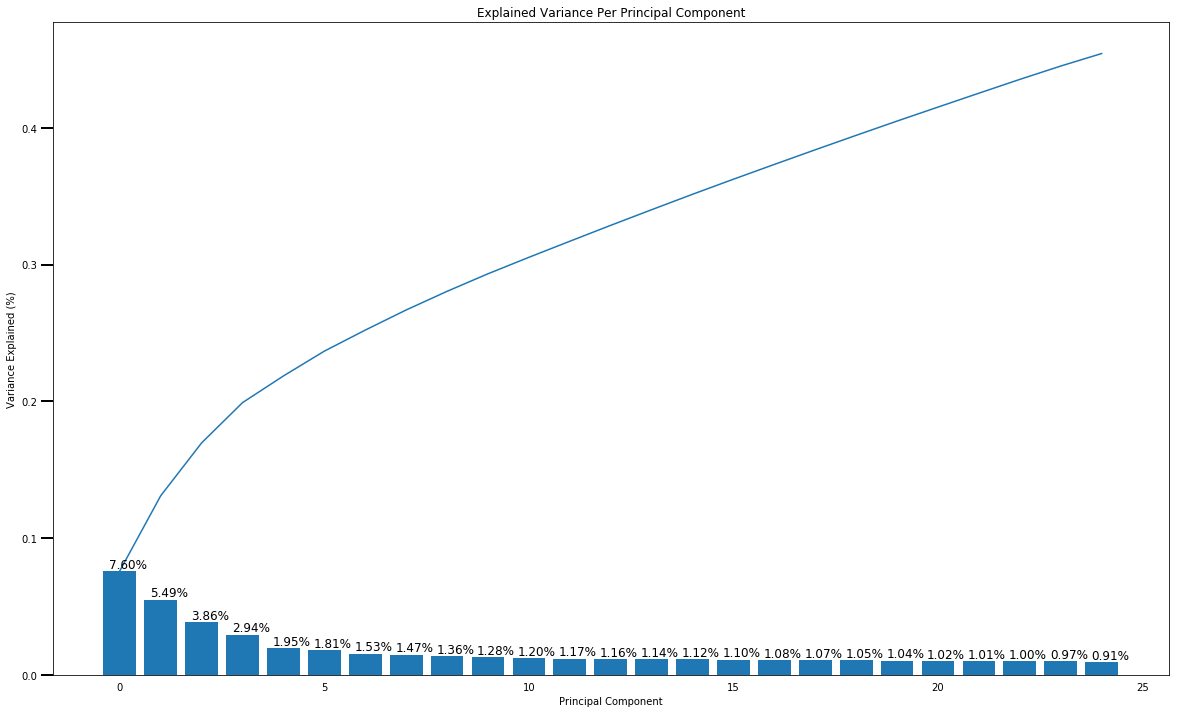

In [34]:
scree_plot(pca)

In [35]:
# Calculate cumulative variance and select number of components to retain

cumulative_sum = np.cumsum(pca_res['Explained_Variance'].apply(lambda x: x*100))
data = [('Dimension', list(pca_res.index)), ('cumu_var', list(cumulative_sum))]
variance_df = pd.DataFrame.from_items(data)

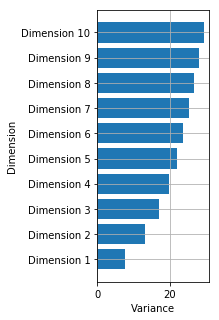

In [36]:
req_comp = variance_df[(variance_df['cumu_var'] >= 0.0) & (variance_df['cumu_var'] <= 30.0)]

plt.figure(figsize=(2,5))
plt.barh(range(len(req_comp)), req_comp.cumu_var.tolist())
plt.yticks(range(len(req_comp)), req_comp.Dimension.tolist())
plt.xlabel('Variance')
plt.ylabel('Dimension')
plt.grid()

In [37]:
variance_df[(variance_df['cumu_var'] >= 0.0) & (variance_df['cumu_var'] <= 30.0)]

,Dimension,cumu_var
0,Dimension 1,7.60
1,Dimension 2,13.09
2,Dimension 3,16.96
3,Dimension 4,19.90
4,Dimension 5,21.85
5,Dimension 6,23.66
6,Dimension 7,25.20
7,Dimension 8,26.67
8,Dimension 9,28.03
9,Dimension 10,29.31


In [38]:
# Re-apply PCA to the data while selecting for number of components to retain.

# PCA with 4 components
n_components = 4
pca = PCA(n_components)
X_pca = pca.fit_transform(scaled_df)

### Discussion 2.2: Perform Dimensionality Reduction

PCA was use to identify dimensions in data that reflect maximal variance. A scree plot (only first 25 dimensions shown above for clarity- more dimension were evaluated) was generated. Based on the scree plot, first 4 components seemed to be reasonable choice after which there was mimimal addition to the amount of variability. The first 4 dimensions accounted for about 20% of variance.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [43]:
# HINT: Try defining a function here or in a new cell that you can reuse in other cells.

def component_mapping(pca, scaled_df, n_comp):
    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = scaled_df.keys())
    components.index = dimensions
    pca_res = components
    n_st = n_comp - 1
    map_pc = pca_res[n_st:n_comp].T
    
    return map_pc


In [44]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
#dimensions
map_pc1 = component_mapping(pca, scaled_df, 1)

# Top features positively correlated
print("Top features positively correlated:")
display(map_pc1.sort_values(by='Dimension 1', ascending=False).head())

print()
print()

# Top features negatively correlated
print("Top features negatively correlated:")
display(map_pc1.sort_values(by='Dimension 1', ascending=True).head())

Top features positively correlated:


,Dimension 1
LP_STATUS_GROB_1.0,0.1976
HH_EINKOMMEN_SCORE,0.1884
CAMEO_INTL_2015_WLTH,0.1847
PLZ8_ANTG3,0.1773
PLZ8_ANTG4,0.1760




Top features negatively correlated:


,Dimension 1
FINANZ_MINIMALIST,-0.1916
KBA05_ANTG1,-0.1807
MOBI_REGIO,-0.1748
PLZ8_ANTG1,-0.1676
KBA05_GBZ,-0.1480


In [45]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

map_pc2 = component_mapping(pca, scaled_df, 2)

# Top features positively correlated
print("Top features positively correlated:")
display(map_pc2.sort_values(by='Dimension 2', ascending=False).head())

print()
print()

# Top features negatively correlated
print("Top features negatively correlated:")
display(map_pc2.sort_values(by='Dimension 2', ascending=True).head())


Top features positively correlated:


,Dimension 2
ALTERSKATEGORIE_GROB,0.2332
FINANZ_VORSORGER,0.2188
ZABEOTYP_3,0.2035
SEMIO_ERL,0.1920
SEMIO_LUST,0.1663




Top features negatively correlated:


,Dimension 2
FINANZ_SPARER,-0.2264
SEMIO_REL,-0.2207
PRAEGENDE_JUGENDJAHRE_DEC,-0.2161
FINANZ_UNAUFFAELLIGER,-0.2143
SEMIO_TRADV,-0.2112


In [46]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

map_pc3 = component_mapping(pca, scaled_df, 3)

# Top features positively correlated
print("Top features positively correlated:")
display(map_pc3.sort_values(by='Dimension 3', ascending=False).head())

print()
print()

# Top features negatively correlated
print("Top features negatively correlated:")
display(map_pc3.sort_values(by='Dimension 3', ascending=True).head())

Top features positively correlated:


,Dimension 3
ANREDE_KZ_1,0.3280
SEMIO_VERT,0.3000
SEMIO_SOZ,0.2371
SEMIO_FAM,0.2355
SEMIO_KULT,0.2271




Top features negatively correlated:


,Dimension 3
ANREDE_KZ_2,-0.3280
SEMIO_KAEM,-0.2932
SEMIO_DOM,-0.2628
SEMIO_KRIT,-0.2436
SEMIO_ERL,-0.1826


### Discussion 2.3: Interpret Principal Components

The top 5 features that map to Dimension 1 and are positive associated include social status, household net income, wealth, and greater than 10 family houses in the PLZ 8 region. While the negatively associated features for this dimension include financial typology, neighborhood information like family houses in the microcell and PLZ8 region, movement patterns. These features are potentially valuable to serve as distinguishing factors among the individuals for the given demographic data. For the Dimension two, the financial and personality typology, and energy consumption appears to be strongly associated (positively). There is also some correlation (-ve) among time based aspects of movement of person's youth. The personality typology is more strongly associated with Dimension 3 and seems to be unique aspect of dimension 3. The gender is also a unique aspect strongly associated with dimension 3. Features having large weights of the same sign (both positive or both negative) tend vary similarly. While features with different signs can be expected to show a negative correlation.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [47]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.
#from sklearn.cluster import KMeans
    
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center, n_init=30)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score
  

K = 1 : Score = 31609784.3599
K = 2 : Score = 22424513.5483
K = 3 : Score = 18284822.5059
K = 4 : Score = 15224137.1725
K = 5 : Score = 13116323.5608
K = 6 : Score = 11534275.2816
K = 7 : Score = 10210196.2327
K = 8 : Score = 9076395.56943
K = 9 : Score = 8214159.60287
K = 10 : Score = 7408682.12682
K = 11 : Score = 6994490.1089
K = 12 : Score = 6636556.88546
K = 13 : Score = 6316930.54756
K = 14 : Score = 6001301.93315


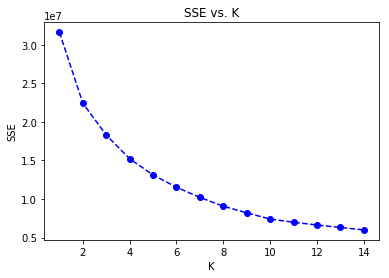

In [48]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

scores = []
centers = list(range(1,15))
data = X_pca

for center in centers:
    scr = get_kmeans_score(data, center)
    print("K =", center, ":", "Score =", scr)
    scores.append(scr)

#plt.figure(figsize=(20, 10))
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K'); 

In [49]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
# Selecting 4 clusters as identified from plot and scores above

k_means = KMeans(n_clusters=4, n_init=30)
final_model = k_means.fit(X_pca)
X_clustered = final_model.predict(X_pca)


In [50]:
display(X_clustered[0:10])
display(final_model.labels_[0:10])

array([2, 0, 3, 1, 3, 2, 3, 0, 0, 1], dtype=int32)

array([2, 0, 3, 1, 3, 2, 3, 0, 0, 1], dtype=int32)

In [51]:
#display(final_model.cluster_centers_[0])
#display(len(final_model.labels_))
#display(len(final_model.cluster_centers_[5]))
#display(len(X_pca))
clust_demo_df = demo_df
clust_demo_df['Cluster_Label'] = final_model.labels_
display(clust_demo_df.head())

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DEC,PRAEGENDE_JUGENDJAHRE_MVMT,CAMEO_INTL_2015_WLTH,CAMEO_INTL_2015_LSTG,WOHNLAGE_RURAL,PLZ8_BTYPE,Cluster_Label
1,1.0,1,5,2,5,4,5,3.0,1.0,5,...,0,0,0,6.0,0.0,5.0,1.0,0.0,0.0,2
2,3.0,1,4,1,2,3,5,3.0,3.0,4,...,0,0,0,6.0,1.0,2.0,4.0,0.0,0.0,0
3,4.0,4,2,5,2,1,2,2.0,2.0,5,...,0,0,0,4.0,0.0,1.0,2.0,1.0,0.0,3
4,3.0,4,3,4,1,3,2,3.0,5.0,6,...,0,0,0,4.0,0.0,4.0,3.0,0.0,0.0,1
5,1.0,3,1,5,2,2,5,3.0,3.0,2,...,0,0,0,2.0,0.0,5.0,4.0,1.0,0.0,3


In [52]:
# Map cluster centers results back to Original data
demo_inv_pca_centers = pca.inverse_transform(final_model.cluster_centers_)
demo_map_back = scaler.inverse_transform(demo_inv_pca_centers)
demo_map_back = np.round(demo_map_back, 2)
demo_map_df = pd.DataFrame(demo_map_back, columns = list(imputed_df.columns))


In [53]:
# Test mapping back cluster centers to top 5 features positively correlated with Dimension 1
display(demo_map_df[list(map_pc1.sort_values(by='Dimension 1', ascending=False).head().index)])

,LP_STATUS_GROB_1.0,HH_EINKOMMEN_SCORE,CAMEO_INTL_2015_WLTH,PLZ8_ANTG3,PLZ8_ANTG4
0,-0.02,2.40,1.86,1.18,0.40
1,0.66,5.33,4.21,2.20,1.14
2,0.76,5.38,4.09,2.11,1.08
3,0.12,4.03,2.50,0.72,0.10


### Discussion 3.1: Apply Clustering to General Population

Based on the plotted results from number of clusters vs. scores obtained, having 4 clusters for further analysis seems reasonalble. Although a clear cut elbow was not visible, investigating the decline in scores after 4 clusters was reasonalbly low (in two separate runs). So 4 clusters was selected.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [54]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep=';')
display(customers.shape)
display(customers.head())

(191652, 85)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [55]:
customers.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,191652.000000,191652.000000,191652.000000,188439.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,...,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,141176.000000,141176.000000,141176.000000
mean,0.344359,3.060907,1.376432,3.677928,3.963773,2.057051,4.183317,2.439808,2.646176,2.781176,...,2.537404,2.731510,1.388817,0.539939,1.556607,3.634893,3.622192,2.824850,5.119517,2.898510
std,1.391672,1.086254,0.484492,1.813975,1.036230,1.319422,0.995365,1.697932,1.586506,1.147353,...,0.904927,0.840922,0.885038,0.637048,1.185736,0.933660,1.008472,1.012415,2.159184,1.422683
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,-1.000000,3.000000,1.000000,2.000000,3.000000,1.000000,3.000000,1.000000,1.000000,2.000000,...,2.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,2.000000,4.000000,2.000000
50%,0.000000,3.000000,1.000000,4.000000,4.000000,1.000000,5.000000,2.000000,2.000000,3.000000,...,3.000000,3.000000,1.000000,0.000000,1.000000,3.000000,4.000000,3.000000,5.000000,3.000000
75%,2.000000,4.000000,2.000000,6.000000,5.000000,4.000000,5.000000,5.000000,5.000000,3.000000,...,3.000000,3.000000,2.000000,1.000000,1.000000,4.000000,4.000000,4.000000,7.000000,4.000000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.000000


In [56]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# 1. Preprocessing and feature tansformation
customer_df = clean_data(customers, feat_info)
display(customer_df.shape)
display(customer_df.head())

(141725, 198)

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DEC,PRAEGENDE_JUGENDJAHRE_MVMT,CAMEO_INTL_2015_WLTH,CAMEO_INTL_2015_LSTG,WOHNLAGE_RURAL,PLZ8_BTYPE
0,4.0,5,1,5,1,2,2,1.0,5.0,6,...,0,0,0,0,2.0,1.0,1.0,3.0,1.0,0.0
2,4.0,5,1,5,1,4,4,2.0,5.0,2,...,0,0,0,0,2.0,1.0,3.0,4.0,0.0,0.0
3,4.0,5,1,5,2,1,2,2.0,3.0,6,...,0,0,0,0,1.0,0.0,2.0,4.0,1.0,0.0
4,3.0,3,1,4,4,5,2,3.0,5.0,4,...,0,0,0,0,4.0,0.0,4.0,1.0,0.0,0.0
5,3.0,5,1,5,1,2,3,3.0,3.0,6,...,0,0,0,0,2.0,1.0,3.0,4.0,0.0,0.0


In [57]:
# get_dummies encoding was failing to create this column
idx = customer_df.columns.get_loc('GEBAEUDETYP_6.0')
new_col = np.zeros(141725) 
customer_df.insert(loc=idx, column='GEBAEUDETYP_5.0', value=new_col)

In [58]:
display(customer_df.shape)

(141725, 199)

In [59]:
print(list(customer_df.columns))
#display(customer_df.head())

['ALTERSKATEGORIE_GROB', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEIT', 'ORTSGR_KLS9', 'RELAT_AB', 'ANREDE_KZ_1', 'ANREDE_KZ_2', 'CJT_GESAMTTYP_1.0', 'CJT_GESAMTTYP_2.0', 'CJT_GESAMTTYP_3.0', 'CJT_GESAMTTYP_4.0', 'CJT_GESAMTTYP_5.0', 'CJT_GESA

In [60]:
# Apply Imputer

cust_imputed_df = pd.DataFrame(fill_NaN.transform(customer_df))
cust_imputed_df.columns = customer_df.columns
cust_imputed_df.index = customer_df.index

cust_imputed_df.head()


,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DEC,PRAEGENDE_JUGENDJAHRE_MVMT,CAMEO_INTL_2015_WLTH,CAMEO_INTL_2015_LSTG,WOHNLAGE_RURAL,PLZ8_BTYPE
0,4.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,5.0,6.0,...,0.0,0.0,0.0,0.0,2.0,1.0,1.0,3.0,1.0,0.0
2,4.0,5.0,1.0,5.0,1.0,4.0,4.0,2.0,5.0,2.0,...,0.0,0.0,0.0,0.0,2.0,1.0,3.0,4.0,0.0,0.0
3,4.0,5.0,1.0,5.0,2.0,1.0,2.0,2.0,3.0,6.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2.0,4.0,1.0,0.0
4,3.0,3.0,1.0,4.0,4.0,5.0,2.0,3.0,5.0,4.0,...,0.0,0.0,0.0,0.0,4.0,0.0,4.0,1.0,0.0,0.0
5,3.0,5.0,1.0,5.0,1.0,2.0,3.0,3.0,3.0,6.0,...,0.0,0.0,0.0,0.0,2.0,1.0,3.0,4.0,0.0,0.0


In [61]:
# Apply feature scaling to the customer data.

cust_scaled_df = pd.DataFrame(scaler.transform(cust_imputed_df))
cust_scaled_df.columns = cust_imputed_df.columns
cust_scaled_df.index = cust_imputed_df.index

cust_scaled_df.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DEC,PRAEGENDE_JUGENDJAHRE_MVMT,CAMEO_INTL_2015_WLTH,CAMEO_INTL_2015_LSTG,WOHNLAGE_RURAL,PLZ8_BTYPE
0,1.179058,1.409062,-1.155523,1.138176,-1.249989,-0.470419,-0.791198,-1.262319,1.070090,0.958427,...,-0.189538,-0.179781,-0.192767,-0.089763,-1.324344,1.885350,-1.504557,0.099505,1.809020,-0.372694
2,1.179058,1.409062,-1.155523,1.138176,-1.249989,0.958624,0.629148,-0.112469,1.070090,-1.102444,...,-0.189538,-0.179781,-0.192767,-0.089763,-1.324344,1.885350,-0.159250,0.766015,-0.552786,-0.372694
3,1.179058,1.409062,-1.155523,1.138176,-0.571003,-1.184941,-0.791198,-0.112469,-0.286693,0.958427,...,-0.189538,-0.179781,-0.192767,-0.089763,-1.932989,-0.530406,-0.831903,0.766015,1.809020,-0.372694
4,0.208164,-0.042764,-1.155523,0.411889,0.786970,1.673145,-0.791198,1.037380,1.070090,-0.072009,...,-0.189538,-0.179781,-0.192767,-0.089763,-0.107055,-0.530406,0.513404,-1.233515,-0.552786,-0.372694
5,0.208164,1.409062,-1.155523,1.138176,-1.249989,-0.470419,-0.081025,1.037380,-0.286693,0.958427,...,-0.189538,-0.179781,-0.192767,-0.089763,-1.324344,1.885350,-0.159250,0.766015,-0.552786,-0.372694


In [62]:
# PCA with 4 components

CX_pca = pca.transform(cust_scaled_df)

In [63]:
# Use the k-means model with 4 clusters

cust_clustered = final_model.predict(CX_pca)

In [64]:
clust_cust_df = customer_df
clust_cust_df['Cluster_Label'] = cust_clustered
clust_cust_df.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DEC,PRAEGENDE_JUGENDJAHRE_MVMT,CAMEO_INTL_2015_WLTH,CAMEO_INTL_2015_LSTG,WOHNLAGE_RURAL,PLZ8_BTYPE,Cluster_Label
0,4.0,5,1,5,1,2,2,1.0,5.0,6,...,0,0,0,2.0,1.0,1.0,3.0,1.0,0.0,0
2,4.0,5,1,5,1,4,4,2.0,5.0,2,...,0,0,0,2.0,1.0,3.0,4.0,0.0,0.0,0
3,4.0,5,1,5,2,1,2,2.0,3.0,6,...,0,0,0,1.0,0.0,2.0,4.0,1.0,0.0,3
4,3.0,3,1,4,4,5,2,3.0,5.0,4,...,0,0,0,4.0,0.0,4.0,1.0,0.0,0.0,2
5,3.0,5,1,5,1,2,3,3.0,3.0,6,...,0,0,0,2.0,1.0,3.0,4.0,0.0,0.0,0


In [65]:
# Map cluster centers results back to Original data
cust_inv_pca_centers = pca.inverse_transform(final_model.cluster_centers_)
cust_map_back = scaler.inverse_transform(cust_inv_pca_centers)
cust_map_back = np.round(cust_map_back, 2)
cust_map_df = pd.DataFrame(cust_map_back, columns = list(cust_imputed_df.columns))


In [66]:
# Test mapping back to top 3 features (+ve or -ve) correlated with Dimension 1
dim1_feat_df = cust_map_df[list(map_pc1.sort_values(by='Dimension 1', ascending=False)[0:3].index)
                           + list(map_pc1.sort_values(by='Dimension 1', ascending=True)[0:3].index)]
display(dim1_feat_df)

,LP_STATUS_GROB_1.0,HH_EINKOMMEN_SCORE,CAMEO_INTL_2015_WLTH,FINANZ_MINIMALIST,KBA05_ANTG1,MOBI_REGIO
0,-0.02,2.40,1.86,4.24,2.60,3.93
1,0.66,5.33,4.21,2.95,0.59,1.95
2,0.76,5.38,4.09,1.62,0.57,1.91
3,0.12,4.03,2.50,3.66,2.14,3.66


In [67]:
# Test mapping back to top 3 features (+ve or -ve) correlated with Dimension 2
dim2_feat_df = cust_map_df[list(map_pc2.sort_values(by='Dimension 2', ascending=False)[0:3].index)
                           + list(map_pc2.sort_values(by='Dimension 2', ascending=True)[0:3].index)]
display(dim2_feat_df)

,ALTERSKATEGORIE_GROB,FINANZ_VORSORGER,ZABEOTYP_3,FINANZ_SPARER,SEMIO_REL,PRAEGENDE_JUGENDJAHRE_DEC
0,3.02,3.85,0.26,2.07,3.48,4.05
1,3.46,4.28,0.69,1.86,2.95,3.06
2,1.80,2.15,0.08,4.31,5.60,5.46
3,2.90,3.54,0.35,2.48,3.84,4.12


In [68]:
# Test mapping back to top 3 features (+ve or -ve) correlated with Dimension 3
dim3_feat_df = cust_map_df[list(map_pc3.sort_values(by='Dimension 3', ascending=False)[0:3].index)
                           + list(map_pc3.sort_values(by='Dimension 3', ascending=True)[0:3].index)]
display(dim3_feat_df)

,ANREDE_KZ_1,SEMIO_VERT,SEMIO_SOZ,ANREDE_KZ_2,SEMIO_KAEM,SEMIO_DOM
0,0.53,4.78,4.23,0.47,4.16,4.65
1,0.46,4.15,3.99,0.54,4.62,4.63
2,0.43,3.83,4.48,0.57,4.55,4.82
3,0.50,4.46,3.93,0.50,3.88,4.19


In [71]:
# Test mapping back to top 3 features (+ve or -ve) correlated with Dimension 4
map_pc4 = component_mapping(pca, scaled_df, 4)
dim4_feat_df = cust_map_df[list(map_pc4.sort_values(by='Dimension 4', ascending=False)[0:3].index)
                           + list(map_pc4.sort_values(by='Dimension 4', ascending=True)[0:3].index)]
display(dim4_feat_df)

,GREEN_AVANTGARDE_1,PRAEGENDE_JUGENDJAHRE_MVMT,LP_STATUS_FEIN_10.0,GREEN_AVANTGARDE_0,LP_STATUS_GROB_4.0,WOHNLAGE_RURAL
0,0.86,0.86,0.61,0.14,0.11,0.14
1,0.09,0.09,0.05,0.91,0.09,0.06
2,0.07,0.07,-0.02,0.93,0.02,0.08
3,0.07,0.07,0.06,0.93,0.50,0.58


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

,Label,General,Customer
0,0.0,0.166166,0.356380
1,1.0,0.233461,0.162847
2,2.0,0.230026,0.018455
3,3.0,0.265826,0.201808
4,4.0,0.104521,0.260509


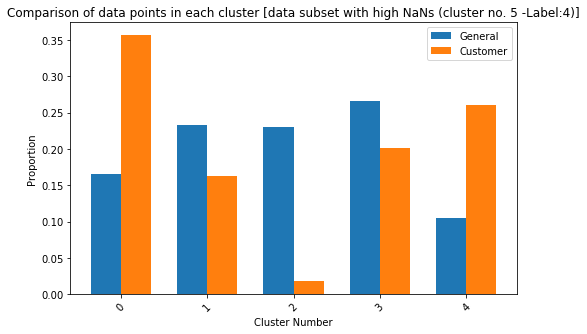

In [72]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.


def comparison_prop(demo_labels_df, cust_labels_df):
    idx = list(range(4))
    demo_label_counts = []
    for i in idx:
        siz = demo_labels_df[demo_labels_df['Cluster_Label'] == i].shape[0]/891221
        demo_label_counts.append(siz)
    cust_label_counts = []
    for i in idx:
        siz = cust_labels_df[cust_labels_df['Cluster_Label'] == i].shape[0]/191652
        cust_label_counts.append(siz)
    df_data = [('Label', idx),
            ('General', demo_label_counts), 
           ('Customer', cust_label_counts)]
    df = pd.DataFrame.from_items(df_data)
    return df

def create_plots(ax, df):
    width = 0.35
    ind = df['Label']
    rects1 = ax.bar(ind, df['General'],width)
    rects2 = ax.bar(ind+width, df['Customer'], width)
    ax.set_ylabel('Proportion')
    ax.set_xlabel('Cluster Number')
    ax.set_title('Comparison of data points in each cluster [data subset with high NaNs (cluster no. 5 -Label:4)]')
    xTickMarks = list(df.index)
    ax.set_xticks(ind+width/2)
    xtickNames = ax.set_xticklabels(xTickMarks)
    plt.setp(xtickNames, rotation=45, fontsize=10)
    ax.legend( (rects1[0], rects2[0]), ('General', 'Customer') )


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
df = comparison_prop(clust_demo_df, clust_cust_df)

# Add additonal data subset with high NaNs as last cluster (cluster no. 5 -Label:4)
gen_prop_highnan = azdias_row_highnan.shape[0]/azdias.shape[0]
cust_prop_highnan = (customers.shape[0]-clust_cust_df.shape[0])/customers.shape[0]
s = [4, gen_prop_highnan, cust_prop_highnan]
df.loc[4] = list(s)
display(df)

create_plots(ax, df)
#plt.tight_layout()
plt.show()


In [75]:
# Differences in individual characteristics between overrepresented (cluster_label 0) 
# and underrepresented (cluster_label 2) clusters in customer dataset (Based on First 4 dimensions)
# Last cluster (4)  was not considered since it is not a result of k-means it is just
# separated out initially based on higher NaNs.

df1 = dim1_feat_df[(dim1_feat_df.index == 0) | (dim1_feat_df.index == 2)]
df2 = dim2_feat_df[(dim2_feat_df.index == 0) | (dim2_feat_df.index == 2)]
df3 = dim3_feat_df[(dim3_feat_df.index == 0) | (dim3_feat_df.index == 2)]
df4 = dim4_feat_df[(dim4_feat_df.index == 0) | (dim4_feat_df.index == 2)]

#display(df1)

final_df = pd.concat([df1, df2, df3, df4], axis=1).T

final_df['diff'] = abs(final_df[0] - final_df[2])
display(final_df[final_df['diff'] >= 0.5].sort_index().drop_duplicates())

,0,2,diff
ALTERSKATEGORIE_GROB,3.02,1.80,1.22
CAMEO_INTL_2015_WLTH,1.86,4.09,2.23
FINANZ_MINIMALIST,4.24,1.62,2.62
FINANZ_SPARER,2.07,4.31,2.24
FINANZ_VORSORGER,3.85,2.15,1.70
GREEN_AVANTGARDE_0,0.14,0.93,0.79
GREEN_AVANTGARDE_1,0.86,0.07,0.79
HH_EINKOMMEN_SCORE,2.40,5.38,2.98
KBA05_ANTG1,2.60,0.57,2.03
LP_STATUS_FEIN_10.0,0.61,-0.02,0.63


## What kinds of people are part of a cluster that is overrepresented in the
## customer data compared to the general population?

### ==> SEE DATAFRAME ABOVE (CLUSTER LABEL: 0) <== ##

1. Estimated Age: Greater than 45 years (45-60 years)
2. Prosperous Households
3. Finance Typology (minimalist) [advocating moderate political policies]: Low to very low
4. Finance saver: high
5. Financial precedent: Low to average
6. Membership in environmental sustainability as part of youth: No
7. Estimated household net income: High to very high
8. Number of 1-2 family houses in the microcell: average to high share
9. Social status, fine scale (top earners): Hard to tell
10. Social status, rough scale (low income earners): No
11. Movement patterns: Low movement
12. Dominating movement of person's youth (decade): 50s
13. Personality typology (SEMIO_REL): Average to high affinity
14. Personality typology (SEMIO_VERT): Low to average affinity

## What kinds of people are part of a cluster that is underrepresented in the
## customer data compared to the general population?

### ==> SEE DATAFRAME ABOVE (CLUSTER LABEL: 2) <== ##

1. Estimated Age: Less than 45 years.
2. Less Affluent Households
3. Finance Typology (minimalist) [advocating moderate political policies]: high to very high
4. Finance saver: low to very low
5. Financial precedent: High
6. Membership in environmental sustainability as part of youth: Yes
7. Estimated household net income: very low to lower
8. Number of 1-2 family houses in the microcell: Nil to lower share
9. Social status, fine scale (top earners): No
10. Social status, rough scale (low income earners): Yes
11. Movement patterns: High movement
12. Dominating movement of person's youth (decade): 60s
13. Personality typology (SEMIO_REL): Low to very low affinity
14. Personality typology (SEMIO_VERT): Average to high affinity

### Discussion 3.3: Compare Customer Data to Demographics Data

The results from the analysis suggests that we can describe segments of the population that are relatively popular or relatively unpopular with the mail-order company. Mapping the customer data to the clusters identified from demographic data shows remarkable difference between over-represented and under-represented groups. A comparison was carried out between the two groups based on key features as identified by their association strenght with first 4 dimensions from PCA analysis. The cluster's centroids was used for comparison. Such comparison indicates that the company's customer base is definitely inclined towards particular segment of the population. Some of the key distinguising characteristics include financial status, life stage, etc. (specific values are mentioned in the description above).

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.